# RAGへのlangfuse+Ragas導入試し

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

# 0. langfuse設定

In [2]:
SEC_KEY = os.environ.get("LANGFUSE_SEC_KEY")
PUB_KEY = os.environ.get("LANGFUSE_PUB_KEY")

'sk-lf-23315176-f92f-487d-9aa6-17355e3cf41a'

In [3]:
from langfuse import Langfuse
from langfuse.callback import CallbackHandler

LANG_SEC_KEY = os.environ.get("LANGFUSE_SEC_KEY")
LANG_PUB_KEY = os.environ.get("LANGFUSE_PUB_KEY")
LANG_HOST = "http://localhost:3000"

# langfuse設定
langfuse = Langfuse(
  secret_key=LANG_SEC_KEY,
  public_key=LANG_PUB_KEY,
  host=LANG_HOST
)

# langfuse callbackの設定
langfuse_handler = CallbackHandler(
    secret_key=LANG_SEC_KEY,
    public_key=LANG_PUB_KEY,
    host=LANG_HOST,
)

In [4]:
# langfese設定確認
print(langfuse.auth_check())
print(langfuse_handler.auth_check())

True
True


# 1. 決算資料読み込みと文章のチャンク化

In [5]:
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# コンテキスト用決算資料読み込み｀
file_path = "./data/ricoh_finance_report.pdf"
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)


# チャンク化
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    separators=["\n\n", "。", "、", "\n", "！", "？", "；", "：", "「", "」", "『", "』", "（", "）", "・", "…", "　"],
)

all_splits = text_splitter.split_documents(pages)


In [6]:
# チャンク結果確認
i = 0
for chunk in all_splits:
    print(chunk.page_content)
    print("---------")
    if i > 3:
        break
    i += 1

FY2024 Q1 決算概要2024年8月 6日株式会社リコー
---------
© RicohAug 6, 20241
本資料に関する注意事項本資料に記載されている、リコー(以下、当社)の現在の計画、見通し、戦略などのうち、歴史的事実でないものは、将来の業績に関する見通しであり、現在入手可能な情報から得られた当社の経営者の判断に基づいております。 従って、実際の業績は異なる結果となる場合がありますので、これらの業績見通しにのみ全面的に依拠なさらないようお願い致します。実際の業績に影響を与えうる重要な要素には、 a)当社の事業領域を取り巻く経済情勢、景気動向、b) 為替レートの変動、 c) 当社の事業領域に関連して発生する急速な技術革新、およびd) 激しい競争にさらされた市場の中で、顧客に受け入れられる製品・サービスを当社が設計・開発・生産し続ける能力、などが含まれます。ただし、業績に影響を与えうる要素はこれらに限定されるものではありません。(参照:「事業等のリスク」https://jp.ricoh.com/IR/risk.html)本資料に他の会社・機関等の名称が掲載されている場合といえども、これらの会社・機関等の利用を当社が推奨するものではありません。本資料に掲載されている情報は、投資勧誘を目的にしたものではありません。投資に関するご決定は、ご自身のご判断において行うようお願い致します。本資料における年号の表記:4月から始まる会計年度の表記としております。(例) FY2024 (2024年度):2024年4月から2025年3月までの会計年度
---------
FY2024 Q1決算概要取締役・CFO 川口 俊2024年度第1四半期決算について、説明申し上げます。本日は、決算説明のあとに企業価値向上プロジェクトについて前回からの補足説明をさせていただきます。
---------
© RicohAug 6, 20243
FY2024 Q1決算のポイント業績株主還元自己株式取得 300億円は予定通り進捗2024年度見通しは変更なし企業価値向上プロジェクトの費用・効果は機関決定に従い適時開示見通し増収減益、社内計画並み企業価値向上プロジェクト費用、一部売上計上の期ずれ等もあり減益リコーデジタルサービスオフィスサービスはストック売上が着実に積み上がり利

# 2. embedding, vector storeへの保存, 及びretrieverの作成

In [7]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma
from uuid import uuid4

In [8]:
# embeddingモデルのインスタンス化
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = Chroma(
    collection_name="ricoh_collection",
    embedding_function=embeddings,
    persist_directory="./data/"
)
uuids = [str(uuid4()) for _ in range(len(all_splits))]

# vector storeへのベクトル登録
vector_store.add_documents(documents=all_splits, ids=uuids)

['9c869351-7e57-43c5-9705-3019cb839ccf',
 '7f14d742-52d6-450d-9a6b-e5e193daa9d6',
 '6642122f-87aa-41b6-9dbf-d123bb5bfa41',
 '6344e6b0-0190-4e16-aba8-fdcc4a64d61c',
 '0463d713-de39-4936-b1f5-dc78d106e811',
 'd1f250e9-c475-4d44-83fa-f30f85e9740c',
 'ae8c653f-f812-4607-85c0-ffec281483a6',
 '587bdd3c-c730-4047-aa4c-01d6069e31af',
 '56f8db65-7eb0-45ee-9e77-c29a481351d2',
 '8237f668-eb5d-4687-8b63-1882ea800f06',
 '31e08e66-ae48-4f1b-b1ad-dfb22fdd6514',
 '852908d5-268c-42a0-a506-87198e33ff78',
 '3010a8df-eae8-4e2b-981f-4e5a10405b7d',
 '265a06ed-0105-49d8-ac04-c8a67f9d4ea3',
 '7cff4ed3-01c3-40eb-95c0-f35c41dc909a',
 '04f830ff-ffd6-4020-ad75-7c8aaeafba8a',
 '9461f13a-c41c-4f05-b3a7-c88251fe0785',
 '1d1b3e01-7b0c-45f1-919b-6ba11b5e207a',
 '810e47f0-b624-4bed-96bc-5c8fc3c8ef55',
 '11f50fc7-da32-4759-b8c0-9579513998fc',
 'bb63ad07-4f20-4f2b-a5a8-c5feae2ad69f',
 'f003eb84-dd20-40ea-93fc-ecb2a0dfb7a9',
 '367a809a-051e-42e7-8f32-6ed018461e9d',
 'e4d2a454-d03d-48f3-a791-40f78c837e56',
 'cf4255e0-a047-

In [9]:
# retrieverの作成
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 3})

# 3. prompt生成と回答、および結果のlangfuse送信

In [10]:
from langchain_openai import ChatOpenAI
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate
import asyncio

### Ragasのセットアップ
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

/Users/pci/miniconda3/envs/study_rag/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAIBase has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Users/pci/miniconda3/envs/study_rag/lib/python3.11/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in _VertexAICommon has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [11]:
# output整形用関数
def print_jp(response):
    ''' 文章改行して表示するための関数'''
    sentence = ""
    for r in response["answer"]:
        sentence += r
        if r == "。":
            print(sentence)
            sentence = ""

In [12]:
### llmとprompt雛型用意

llm = ChatOpenAI(model="gpt-4o-mini")

system_prompt = (
    "You are analyst of company financial data."
    "Use the following pieces of retrieved context to answer the user's question."
    "If you don't know the answer, say that you don't know. Make consice sentences."
    "Question and retreived context are Japanease. So answer in Japanease."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

# inputとcontextを受け取ってpromptを作成し、llmを呼び出す関数
question_answer_chain = create_stuff_documents_chain(llm, prompt)
# retriverとllmを繋ぐ関数
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [14]:
### 質問と正解を渡して、llm実行後、ragasで評価してlangfuseに渡す関数
def do_llm_evaluating(question, ground_truth, rag_chain, langfuse_handler):

    # 回答生成
    # ※ config={"callbacks": [langfuse_handler]}をlangchainのinvokeメソッドに入れる
    response = rag_chain.invoke({"input": question}, config={"callbacks": [langfuse_handler]})

    # コンテキスト取り出し
    context_list = [doc.page_content for doc in response['context']]

    # 回答取り出し
    answer = response['answer']

    # ragasによる評価
    ds = Dataset.from_dict(
        {
            "question": [question],
            "answer": [answer],
            "contexts": [context_list],
            "ground_truth": [ground_truth],
        }
    )


    # 評価算出
    metrics = evaluate(
        ds,
        [faithfulness, answer_relevancy, context_recall, context_precision]
    )
    scores_df = metrics.scores[0]

    # 評価値をlangfuseに送信
    # ※ langfuse.score()メソッドで値を送信できる
    async def score_with_ragas():
        trace_id = langfuse_handler.get_trace_id()
        print(trace_id)
        for key in scores_df.keys():
            langfuse.score(
                name=key,
                value=scores_df[key],
                trace_id=trace_id
            )
    # Ragas評価を非同期で実行
    asyncio.run(score_with_ragas())

    print(question, "\n")
    print_jp(response)
    print()
    print(scores_df)

## 質問1

In [15]:
# 質問と答えの用意
question = "第1四半期の営業利益の状況について、一時要因、体質、経費や為替やその他の視点で教えてください。"

ground_truth = """第1四半期の営業利益に関する要約は以下の通りです：
1. **一時要因**: 企業価値向上プロジェクト費用として39億円を計上。これを除いた営業利益は101億円。
2. **販売ミックス**: 販売ミックスの影響で26億円の減益。前年の特需が今期には無く、加えて輸送遅延により一部売上が次期にずれ込む。これらは第2四半期後半に挽回予定。
3. **体質強化**: コストダウン効果が表れ、リコーデジタルプロダクツで2桁の改善が進む。
4. **経費増**: 43億円の経費増（在庫引当13億円を含む）も、販売ミックスの未達分を抑制効果でカバー。
5. **為替影響**: 円安（ドル・ユーロが18円安）が収益を大きく押し上げた。
6. **企業価値向上プロジェクト**: 「販売サービス体制の見直し」等の費用を計上。一部施策は前倒しで進行。
全体として、計画外の費用増加も抑制努力で吸収し、体質改善を進める一方で、輸送遅延の影響を次期で挽回予定。"""


# llm実行
do_llm_evaluating(question, ground_truth, rag_chain, langfuse_handler)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

3a301ec6-dd98-48b5-a020-1c445c924677
第1四半期の営業利益の状況について、一時要因、体質、経費や為替やその他の視点で教えてください。 

2024年度第1四半期の営業利益は63億円で、前年同期比で38億円減少しました。
この減少の一因として、約39億円の企業価値向上プロジェクトの費用が含まれています。
このため、これらの一時要因を除くと、営業利益はほぼ昨年並みの実績となります。
また、売上高は7.4%増加し5,743億円でしたが、販管費の増加も影響しています。
為替については、特定の影響は示されていません。
全体的に、体質や経費の面で改善が求められる状況です。

{'faithfulness': 0.75, 'answer_relevancy': 0.0, 'context_recall': 0.5, 'context_precision': 0.9999999999666667}


## 質問2

In [16]:
# 質問と答えの用意
question = "北米事業の状況について教えてください。"

ground_truth = """###
北米事業は、一定の収益性を維持しながら成長を目指しており、2024年度第1四半期では売上高が前年同期比 **11.8%増加し、417億円** となりました。
BPS（Business Process Services）はオフサイト業務を中心に好調で、収益性向上が確認されています。
また、ワークプレイスエクスペリエンス（WE）は、Cenero買収によるシナジー拡大が進んでおり、北米の既存顧客への導入が進展しました。
ただし、一部大型案件で期ズレが発生し、短期的な業績に影響しています。
また、2023年度にeDiscovery事業を売却したことによる一過性の影響で、短期的な売上減少が発生しています。
しかし、Cenero買収を含むデジタルサービス分野の強化により、北米事業は今後も拡大が期待されています。
総じて、納品遅延や事業売却の影響があるものの、買収企業との統合効果により中長期的な成長が見込まれます。
次期以降、大型案件の進捗と統合シナジーの実現により、更なる業績の改善が期待されます。"""


# llm実行
do_llm_evaluating(question, ground_truth, rag_chain, langfuse_handler)

Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

deec7900-1acd-42aa-8e69-87df5211db60
北米事業の状況について教えてください。 

北米事業は、BPS（ビジネスプロセスサービス）がオフサイト中心に好調です。
また、ワークプレイスエクスペリエンスでは、買収したCeneroとのシナジーが進展しています。
ただし、第1四半期には一部の大型案件の期ずれが発生しており、事業売却の影響で売上が減少しています。
全体的には前年同期比で9%の成長を見せています。

{'faithfulness': 0.8, 'answer_relevancy': 0.7889129288224047, 'context_recall': 1.0, 'context_precision': 0.9999999999666667}


# langfuse dashbord確認

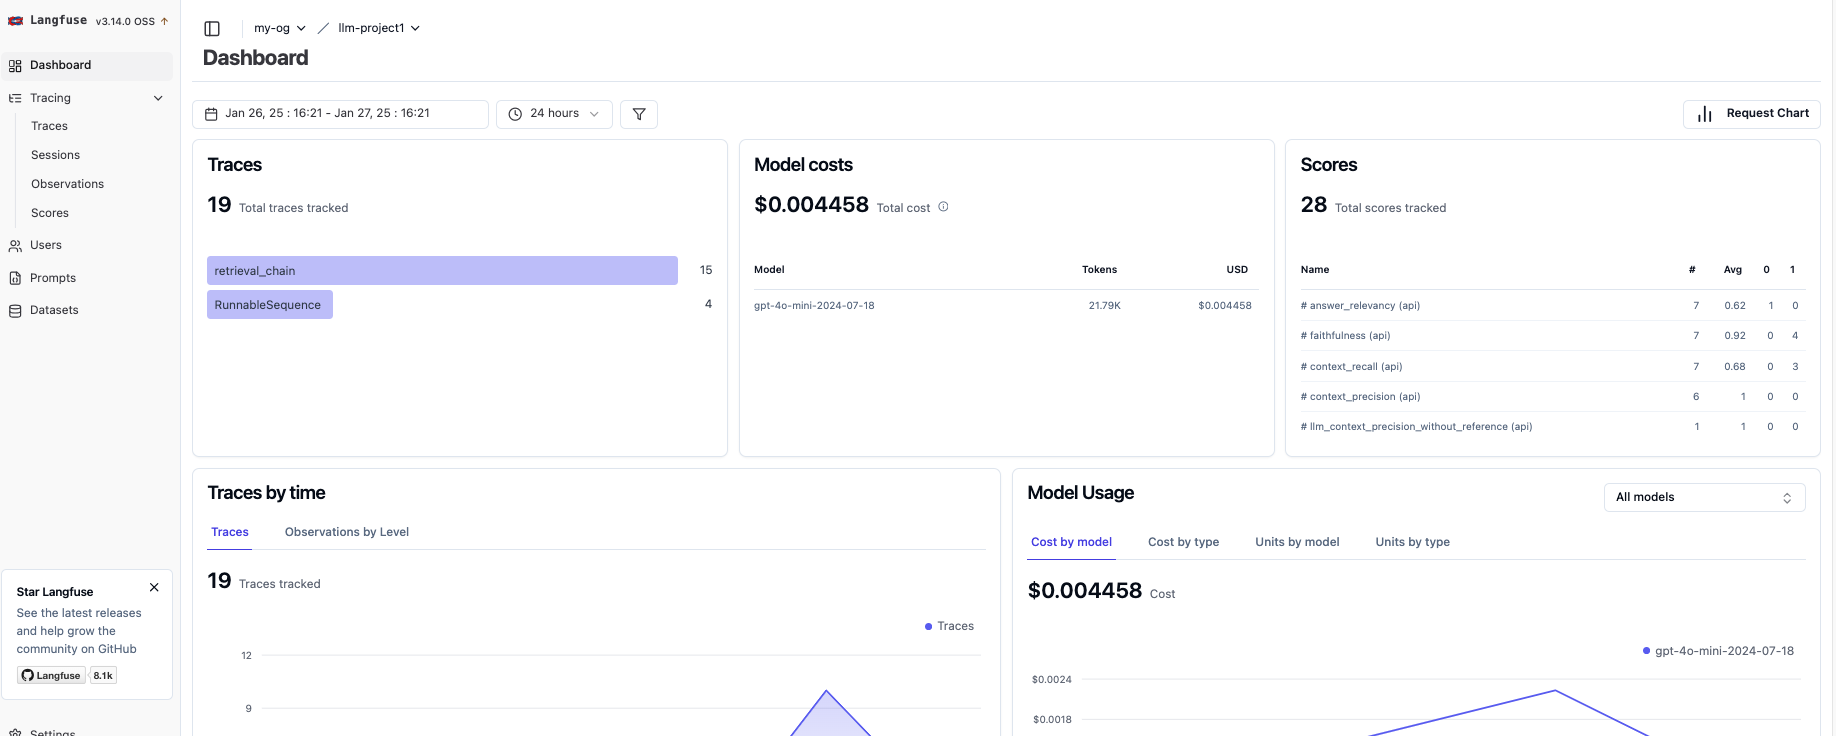

In [17]:
from PIL import Image
im = Image.open("./data/langfuse_dashbord.png")
im